In [1]:
cd ../TileEM/

/srv/data/home/jlee782/crowd-seg/analysis/TileEM


In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
from paper_visualizations import * 
from PixelEM import * 
from test_sample import test_sample_obj
import json
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [3]:
# df = pd.read_csv("all_info.csv",index_col=0)
df_object_batch = pd.read_csv("all_object_batch_info.csv",index_col=0)
df_worker = pd.read_csv("all_worker_response_info.csv",index_col=0)
df_object = pd.read_csv("all_object_info.csv",index_col=0)
df_tile = pd.read_csv("all_tile_info.csv",index_col=0)
df_worker_tile = pd.read_csv("all_worker_tile_info.csv",index_col=0)
df_tile["gt overlap norm tarea"]=df_tile["gt overlap area"]/df_tile["tile area"]
df = df_worker.merge(df_tile)

# Histogram of mistakes: 
- treat if overlap fraction >0.5 then we pick it, what is the accumlated area of mistake (of the external area) that we would make 
- start off by saying that > 0.5 overlap we pick, so "error area" = outside area of the tile, and <= 0.5 overlap we discard the tile in which case "error area" = intersection area.

In [4]:
from math import log10, floor
def round_to_1(x):
    return str(int(round(x, -int(floor(log10(abs(x))))+1)))

In [36]:
def two_bars(dataA,dataB,bin_edges,small_tiles):
    ind = np.arange(len(dataA))   
    width = 0.35        
    fig, ax = plt.subplots()
    rects1 = ax.bar(ind, dataA, width, color='r')
    rects2 = ax.bar(ind + width, dataB, width, color='b')
    ax.set_xticks(ind + width / 2)
    ax.legend((rects1[0], rects2[0]), ('Overselect', 'Underselect'))
    labels = []
    for i in range(len(dataA)):
        if small_tiles: 
            labels.append(str(round(bin_edges[i],2))+'~'+str(round(bin_edges[i+1],2)))
        else: 
            labels.append(round_to_1(bin_edges[i])+'~'+round_to_1(bin_edges[i+1]))
            
    ax.set_xticklabels(labels, rotation='vertical')
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    '%d' % int(height),
                    ha='center', va='bottom')

#     autolabel(rects1)
#     autolabel(rects2)



In [46]:
def plot_mistake_area(batch,objid,small_tiles,N):
    df_tile["tile overlap frac"]=df_tile["gt overlap area"]/df_tile["tile area"]
    df_tile["outside area"]=df_tile["tile area"]-df_tile["gt overlap area"]
    df_tile_subset = df_tile[(df_tile["batch"]==batch)&(df_tile["objid"]==objid)]
    tile_lst = np.array(list(set(df_tile_subset["tile id"])))
    tile_areas = list(df_tile_subset["tile area"])
    if (small_tiles): 
        hist,bin_edges = np.histogram(tile_areas,bins=N,range=(0.01,mean(tile_areas)))
    else: 
        hist,bin_edges = np.histogram(tile_areas,bins=N)
    bin_idx = np.digitize(tile_areas,bin_edges)

    mistake_area_overselect = []
    mistake_area_discard = []

    for i in range(N):
        tidxs =  np.where(bin_idx==i)[0]
        area_overselect = 0
        area_discard = 0
        for tidx in tidxs: 
            df_selected = df_tile_subset[df_tile_subset["tile id"]==tidx]
            if float(df_selected["tile overlap frac"])>=0.5:
                # If we pick this tile then we should penalize the outside 
                area_overselect += float(df_selected["outside area"])
                #mistake_area_overselect.append(float(df_selected["outside area"]))
            else: 
                area_discard += float(df_selected["gt overlap area"])
                #mistake_area_discard.append(float(df_selected["gt overlap area"]))
        mistake_area_overselect.append(area_overselect)
        mistake_area_discard.append(area_discard)
    two_bars(mistake_area_overselect,mistake_area_discard,bin_edges,small_tiles)
    
    # add some text for labels, title and axes ticks
    plt.ylabel('Sum (Mistake Area)')
    if small_tiles:
        plt.title('Total Mistake area by area bins ({};obj{}) [Small; N={}]'.format(batch,objid,N),fontsize=12)
    else: 
        plt.title('Total Mistake area by area bins ({};obj{}) [N={}]'.format(batch,objid,N),fontsize=12)

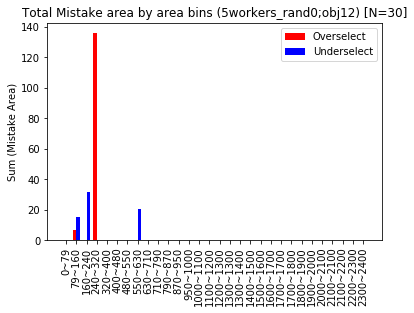

In [47]:
plot_mistake_area('5workers_rand0',12,False,30)

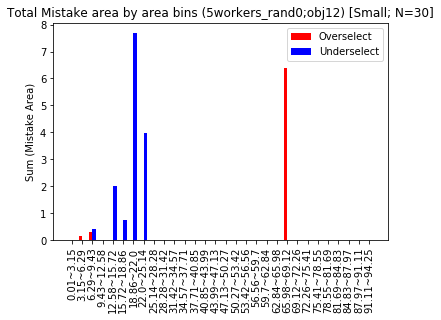

In [48]:
plot_mistake_area('5workers_rand0',12,True,30)

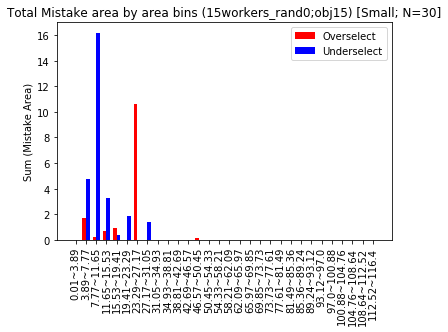

In [49]:
plot_mistake_area('15workers_rand0',15,True,30)

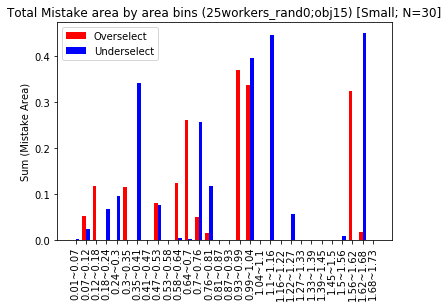

In [56]:
plot_mistake_area('25workers_rand0',15,True,30)

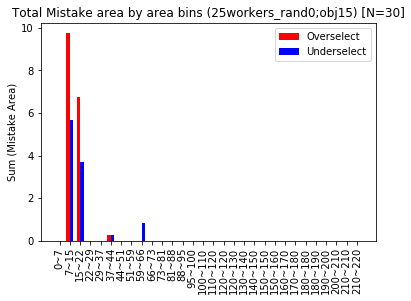

In [55]:
plot_mistake_area('25workers_rand0',15,False,30)

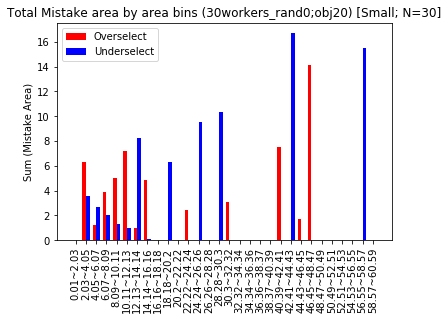

In [52]:
plot_mistake_area('30workers_rand0',20,True,30)

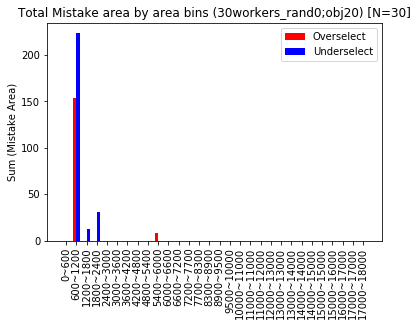

In [53]:
plot_mistake_area('30workers_rand0',20,False,30)

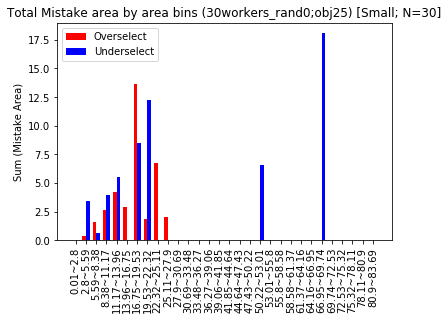

In [54]:
plot_mistake_area('30workers_rand0',25,True,30)